##  **Preditor para o Sistema de Compartilhamento de Bicicletas de Seoul**
O uso de bicicletas de aluguel tem se tornado uma solução cada vez mais popular em muitas cidades ao redor do mundo, contribuindo para a melhoria da mobilidade urbana. Este serviço é uma alternativa sustentável e prática para o transporte em áreas densamente povoadas, ajudando a reduzir o tráfego de veículos motorizados e promovendo a saúde pública. Para garantir a eficácia do sistema, é crucial que as bicicletas estejam disponíveis e acessíveis no momento certo, minimizando o tempo de espera dos usuários e evitando a falta ou o excesso de bicicletas em determinados locais.

<center><img alt="Foto sistema de bicicletas" width="35%" src="https://img.koreatimes.co.kr/upload/newsV2/images/160919_p03_seoul.jpg/dims/resize/740/optimize"></center>



### **Import das bibliotecas**

Iremos importar o conjunto de bibliotecas que serão neceassárias para realizara a análise exploratória dos dados(EDA) carregando o conjunto de dados. Utilizaremos o repositório UCIML para obter o conjunto de dados sobre a demanda de bicicletas de aluguel em Seoul.

In [163]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.metrics import mean_squared_error, mean_absolute_error

### Import dos dados

Utilizaremos o repositório UCIML para obter o conjunto de dados sobre a demanda de bicicletas de aluguel em Seoul.

In [164]:
!pip install ucimlrepo

In [165]:
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
seoul_bike_sharing_demand = fetch_ucirepo(id=560) 
  
# data (as pandas dataframes) 
X = seoul_bike_sharing_demand.data.features 
y = seoul_bike_sharing_demand.data.targets 



## **Dicionário de Variáveis**
Abaixo está a descrição dos atributos contidos no conjunto de dados:

- `Date`: Data da inferência.
- `Rented Bike Count`: Número de bicicletas alugadas.
- `Hour`: Hora do dia.
- `Temperature`: Temperatura durante o aluguel (ºC).
- `Humidity`: Umidade durante o aluguel (%).
- `Wind speed`: Velocidade do vento durante o aluguel.
- `Visibility`: Visibilidade durante o aluguel.
- `Dew point temperature`: Ponto de orvalho (ºC).
- `Solar Radiation`: Radiação solar durante o aluguel.
- `Rainfall`: Precipitação durante o aluguel.
- `Snowfall`: Neve durante o aluguel.
- `Seasons`: Estação do ano.
- `Holiday`: Indica se o dia é um feriado.
- `Functioning Day`: Indica se o dia é um dia útil.

In [166]:
df = pd.concat([X, y], axis=1)
df.head()

,Date,Rented Bike Count,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall,Seasons,Holiday,Functioning Day
0,1/12/2017,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
1,1/12/2017,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
2,1/12/2017,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Winter,No Holiday,Yes
3,1/12/2017,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Winter,No Holiday,Yes
4,1/12/2017,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Winter,No Holiday,Yes


### Verificação estatísticas
Vamos verificar as informações básicas do conjunto de dados e analisar as estatísticas descritivas.

In [167]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Date                   8760 non-null   object 
 1   Rented Bike Count      8760 non-null   int64  
 2   Hour                   8760 non-null   int64  
 3   Temperature            8760 non-null   float64
 4   Humidity               8760 non-null   int64  
 5   Wind speed             8760 non-null   float64
 6   Visibility             8760 non-null   int64  
 7   Dew point temperature  8760 non-null   float64
 8   Solar Radiation        8760 non-null   float64
 9   Rainfall               8760 non-null   float64
 10  Snowfall               8760 non-null   float64
 11  Seasons                8760 non-null   object 
 12  Holiday                8760 non-null   object 
 13  Functioning Day        8760 non-null   object 
dtypes: float64(6), int64(4), object(4)
memory usage: 958.3+ 

In [168]:
df.describe()

,Rented Bike Count,Hour,Temperature,Humidity,Wind speed,Visibility,Dew point temperature,Solar Radiation,Rainfall,Snowfall
count,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000,8760.000000
mean,704.602055,11.500000,12.882922,58.226256,1.724909,1436.825799,4.073813,0.569111,0.148687,0.075068
std,644.997468,6.922582,11.944825,20.362413,1.036300,608.298712,13.060369,0.868746,1.128193,0.436746
min,0.000000,0.000000,-17.800000,0.000000,0.000000,27.000000,-30.600000,0.000000,0.000000,0.000000
25%,191.000000,5.750000,3.500000,42.000000,0.900000,940.000000,-4.700000,0.000000,0.000000,0.000000
50%,504.500000,11.500000,13.700000,57.000000,1.500000,1698.000000,5.100000,0.010000,0.000000,0.000000
75%,1065.250000,17.250000,22.500000,74.000000,2.300000,2000.000000,14.800000,0.930000,0.000000,0.000000
max,3556.000000,23.000000,39.400000,98.000000,7.400000,2000.000000,27.200000,3.520000,35.000000,8.800000


In [169]:
df.isnull().sum()

Date                     0
Rented Bike Count        0
Hour                     0
Temperature              0
Humidity                 0
Wind speed               0
Visibility               0
Dew point temperature    0
Solar Radiation          0
Rainfall                 0
Snowfall                 0
Seasons                  0
Holiday                  0
Functioning Day          0
dtype: int64

## **Pré-processamento dos Dados**
Para preparar os dados para análise, vamos realizar as seguintes etapas:

1. Conversão da coluna Date para o formato de data.
2. Remoção de colunas que não são necessárias para o modelo.
3. Constatamos que não há valores nulos em nenhuma das colunas, o que indica que os dados estão completos e prontos para análise.

In [170]:
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')

In [171]:
num_df = df.copy()
num_df = num_df.drop(['Seasons','Holiday','Functioning Day','Rainfall','Snowfall'], axis=1)

### Visualização dos dados

O histograma mostra que a maioria dos aluguéis de bicicletas está concentrada em um intervalo específico, que entre **0 e 500** indicando que há um padrão de demanda comum. 

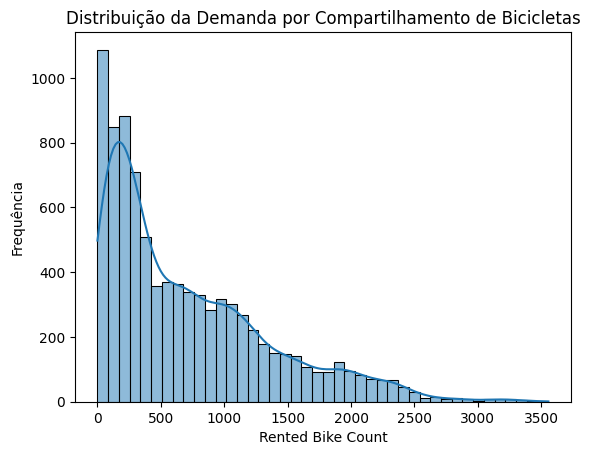

In [172]:
sns.histplot(df['Rented Bike Count'], kde=True)
plt.title('Distribuição da Demanda por Compartilhamento de Bicicletas')
plt.xlabel('Rented Bike Count')
plt.ylabel('Frequência')
plt.show()

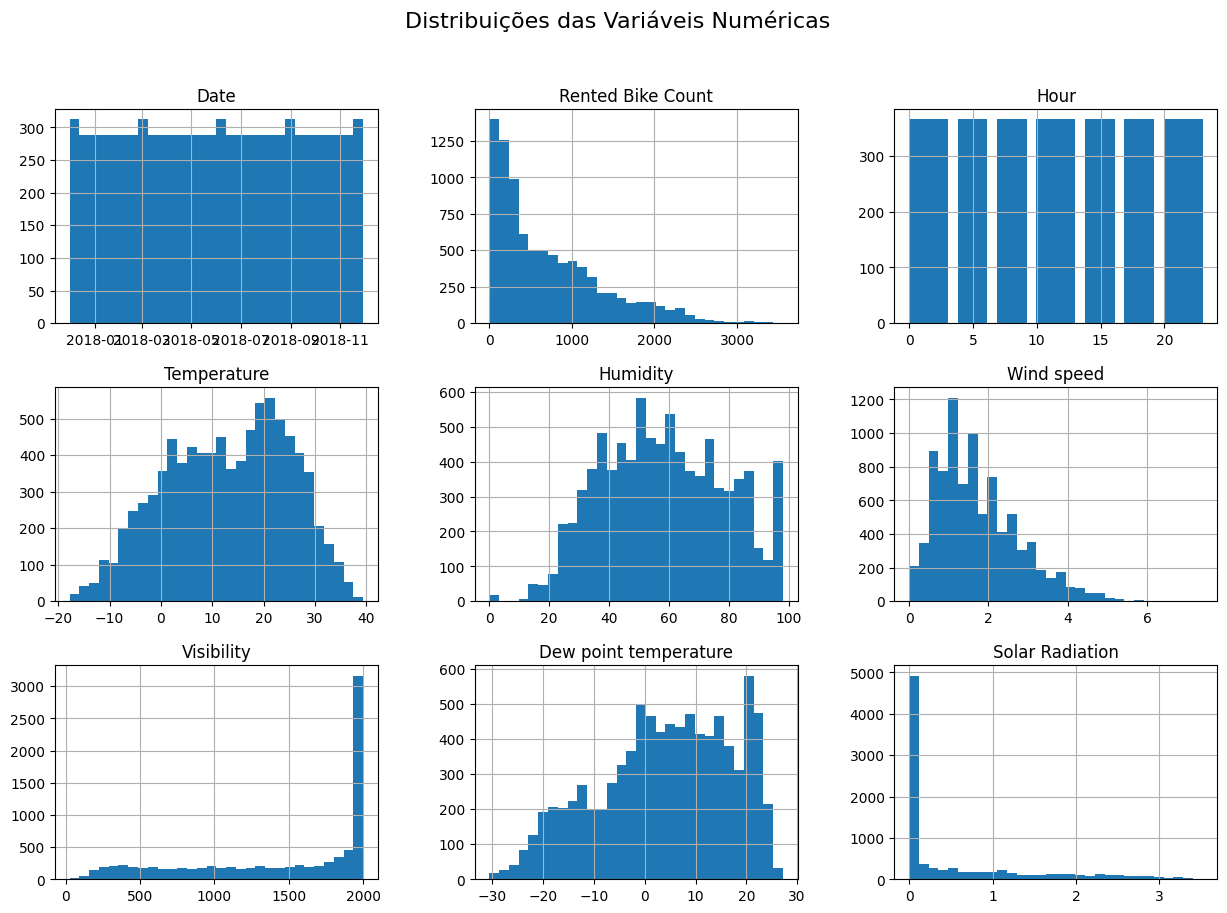

In [173]:
num_df.hist(bins=30, figsize=(15, 10))
plt.suptitle('Distribuições das Variáveis Numéricas',fontsize=16)
plt.show()

## **Matriz de Correlação:**

- Temperatura (0.54): Alta correlação positiva, indicando que um aumento na temperatura está associado a um aumento na demanda de bicicletas.
- Hora (0.41): Correlação positiva moderada, sugerindo que a demanda tende a variar ao longo do dia.
- Umidade (-0.20): Correlação negativa fraca, sugerindo que um aumento na umidade pode estar levemente associado a uma diminuição na demanda.
- Ponto de Orvalho (0.38): Correlação positiva moderada, indicando que a umidade relativa pode influenciar a demanda.
- Radiação Solar (0.26): Correlação positiva fraca, sugerindo que níveis mais altos de radiação solar podem estar associados a uma maior demanda.
Hora:

- Temperatura (0.12): Correlação positiva muito fraca.
- Umidade (-0.24): Correlação negativa fraca.
- Temperatura e Ponto de Orvalho (0.91): Correlação muito alta, indicando que essas variáveis estão fortemente associadas.

- Umidade e Visibilidade (-0.54): Correlação negativa moderada, sugerindo que um aumento na umidade pode estar associado a uma menor visibilidade.

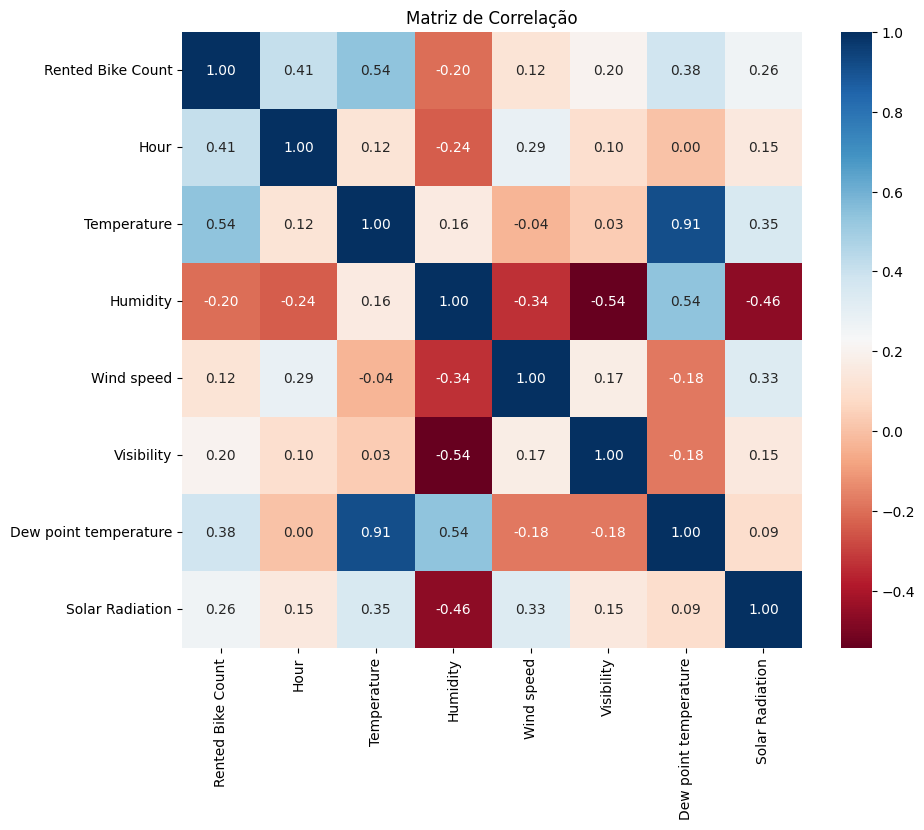

In [174]:
correlation_matrix = df[['Rented Bike Count', 'Hour', 'Temperature', 'Humidity', 'Wind speed', 'Visibility', 'Dew point temperature', 'Solar Radiation']].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='RdBu', fmt='.2f')
plt.title('Matriz de Correlação')
plt.show()



## **Demanda por Compartilhamento de Bicicletas por Dia da Semana**

Distribuição da Demanda: O boxplot revela como a demanda por compartilhamento de bicicletas varia ao longo dos dias da semana.
Outliers: Há muitos outliers de alta demanda em todos os dias da semana, especialmente acima de aproximadamente 2100 bicicletas alugadas. Isso indica que há picos de demanda muito altos que não estão bem representados pela mediana ou pelos quartis. Estes picos podem ser causados por eventos especiais ou outras condições excepcionais.
Comparação entre Dias: A mediana da demanda parece ser relativamente estável entre os dias, mas a presença de outliers sugere que a demanda pode ser bastante variável e influenciada por fatores específicos de dias ou eventos.

C:\Users\joaop\AppData\Local\Temp\ipykernel_17256\1424577082.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Day_of_Week', y='Rented Bike Count',palette='Set1', data=df)


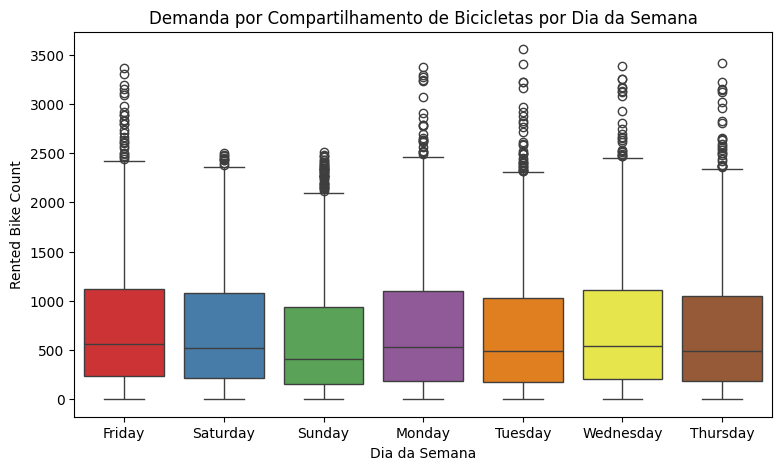

In [175]:
df['Day_of_Week'] = df['Date'].dt.day_name()

plt.figure(figsize=(9,5))
sns.boxplot(x='Day_of_Week', y='Rented Bike Count',palette='Set1', data=df)
plt.title('Demanda por Compartilhamento de Bicicletas por Dia da Semana')
plt.xlabel('Dia da Semana')
plt.ylabel('Rented Bike Count')
plt.show()

## **Demanda por Bicicletas por Estação**


Distribuição da Demanda: O boxplot mostra a demanda por bicicletas em diferentes estações do ano.
Outliers: Observa-se a presença de muitos outliers em todas as estações, indicando que há picos de alta demanda em cada estação. No entanto, no inverno, a variância é menor e os outliers aparecem a partir de aproximadamente 550 bicicletas. Isso sugere que a demanda no inverno é mais estável, mas ainda pode ter picos significativos.
Comparação entre Estações: A demanda tende a ser mais variável em algumas estações do que em outras. Por exemplo, é provável que o verão e a primavera apresentem uma demanda mais alta e mais variabilidade em comparação com o outono e o inverno, onde a demanda pode ser mais consistente.

C:\Users\joaop\AppData\Local\Temp\ipykernel_17256\3954746627.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Seasons', y='Rented Bike Count', palette='Set1', data=df)


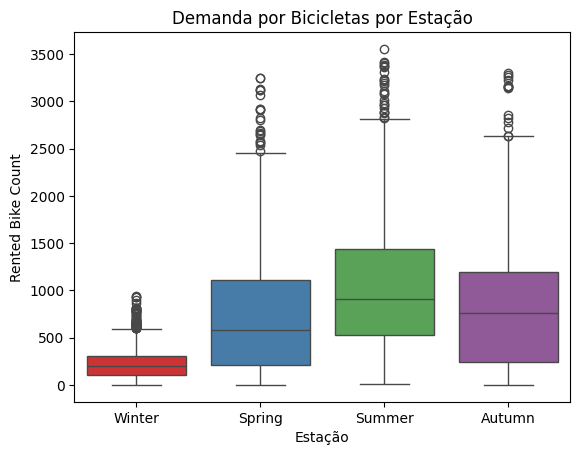

In [176]:
sns.boxplot(x='Seasons', y='Rented Bike Count', palette='Set1', data=df)
plt.title('Demanda por Bicicletas por Estação')
plt.xlabel('Estação')
plt.ylabel('Rented Bike Count')
plt.show()

### **Preparação do modelo** 

Começamos carregando o dataset e separando as features (X) da variável alvo (y). Removemos a coluna Date, pois ela não  seria útil para a modelagem, e mantemos as demais colunas como variáveis preditoras.

In [177]:
X = df.drop(['Date', 'Rented Bike Count'], axis=1)
y = df['Rented Bike Count']


## **Label Encoder**

Algumas colunas são formadas por dados categóricos, são elas: `Rainfall`, `Snowfall`, `Seasons`, `Holiday`, `Functioning Day`; então é preciso codificar numericamente para que os modelos possam utilizá-las. Para isso foi utilizado o `Label Encoder`. Na variável `label_encoders` é armazenado os encoders aplicados a cada coluna, permitindo que a transformação seja revertida posteriormente, se necessário.

In [178]:
label_encoders = {}
for column in ['Rainfall', 'Snowfall', 'Seasons', 'Holiday', 'Functioning Day', 'Day_of_Week']:
    le = LabelEncoder()
    X[column] = le.fit_transform(X[column])
    label_encoders[column] = le

## **Normalização dos dados**

Para garantir que todas as variáveis tenham a mesma escala, aplicamos a normalização dos dados usando StandardScaler. A normalização é crucial em modelos como a MLP, que são sensíveis à escala das variáveis.

In [179]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## **Hold Out**

Dividimos o dataset em conjuntos de treinamento, validação e teste. Primeiramente, separamos 40% dos dados para validação e teste, e em seguida, dividimos esse subconjunto em 50% para validação e 50% para teste. Isso resulta em uma divisão de 60% para treinamento, 20% para validação e 20% para teste

In [180]:
X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.3, random_state=42)


No Pytorch, os dados precisam ser convertidos para tensores, o que permite que sejam utilizados pelos modelos durante o treinamento.

In [181]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val.values, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)


## Modelo de Regressão Linear

O modelo de regressão linear pode ser descrito pela seguinte equação matemática:


$$ \hat{y} = \mathbf{X}\mathbf{w} + b $$


Onde:

- $\hat{y}$ é a predição do modelo.
- $\mathbf{X}$ é a matriz de características, onde cada linha representa uma amostra e cada coluna uma característica.
- $\mathbf{w}$ é o vetor de pesos que o modelo aprende durante o treinamento.
- $\mathbf{b} $ é o termo de bias (ou intercepto).

No contexto do PyTorch, a camada linear `nn.Linear(input_dim, 1)` implementa essa equação, onde `input_dim` é o número de características (o tamanho de $ \mathbf{w}$).

## Função de Perda: Mean Squared Error (MSE)

A função de perda utilizada é o **Erro Quadrático Médio (MSE)**, que mede a diferença média entre as predições do modelo e os valores reais dos alvos:


$$ \text{MSE} = \frac{1}{N} \sum_{i=1}^{N} (\hat{y}_i - y_i)^2 $$


Onde:

- $ \mathbf{N} $ é o número de amostras no conjunto de dados.
- $ \hat{y}_i $ é a predição do modelo para a $ \mathbf{i} $-ésima amostra.
- $ \mathbf{y_i} $ é o valor real da $ \mathbf{i} $-ésima amostra.

A função de perda MSE calcula a média dos quadrados das diferenças entre as predições e os valores reais, penalizando erros maiores de forma mais intensa.

## Gradiente Descendente (SGD)

O algoritmo de otimização usado é o **Gradiente Descendente Estocástico (SGD)**, que ajusta os pesos $ \mathbf{w} $ e $ \mathbf{b} $ para minimizar a função de perda:

$$
\mathbf{w} \leftarrow \mathbf{w} - \eta \nabla_{\mathbf{w}} \text{MSE}
$$
$$
b \leftarrow b - \eta \nabla_{b} \text{MSE}
$$

Onde:

- $\eta$ é a taxa de aprendizado (learning rate).
- $ \nabla_{\mathbf{w}} \text{MSE} $ é o gradiente da função de perda em relação aos pesos.
- $ \nabla_{b} \text{MSE} $ é o gradiente da função de perda em relação ao bias.

O gradiente descendente estocástico atualiza os pesos e o bias a cada amostra, o que ajuda o modelo a encontrar rapidamente uma boa solução, mas pode introduzir flutuações no caminho de convergência.

### Backpropagation

Durante o treinamento, o processo de **backpropagation** calcula o gradiente da função de perda em relação aos pesos e bias, permitindo que o otimizador faça as atualizações necessárias:

```python
loss.backward()


In [182]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1) 
    
    def forward(self, x):
        return self.linear(x) 

linear_model = LinearRegressionModel(input_dim=X_train.shape[1])

criterion = nn.MSELoss()  
optimizer = optim.SGD(linear_model.parameters(), lr=0.01)  

num_epochs = 100
train_losses = []

for epoch in range(num_epochs):
    linear_model.train() 
    optimizer.zero_grad()  
    
    outputs = linear_model(X_train_tensor)  
    loss = criterion(outputs, y_train_tensor) 
    
    loss.backward()  
    optimizer.step() 
    
    train_losses.append(loss.item()) 
    
    if (epoch + 1) % 10 == 0:  
        print(f'Época [{epoch + 1}/{num_epochs}], Perda: {loss.item():.4f}')


Época [10/100], Perda: 657221.6875
Época [20/100], Perda: 486348.9062
Época [30/100], Perda: 381745.7188
Época [40/100], Perda: 315517.2188
Época [50/100], Perda: 272564.1562
Época [60/100], Perda: 244232.1719
Época [70/100], Perda: 225316.5625
Época [80/100], Perda: 212570.5781
Época [90/100], Perda: 203914.3906
Época [100/100], Perda: 197991.6406


### **Resultados**

 É observado uma diminuição consistente na perda ao longo das épocas, sugerindo que o modelo pdoe estar efetivamente aprendendo a mapear as entradas para as saídas corretas.

  Percebe-se que existe a diminuição da perda, que torna-se mais gradual nas últimas épocas, o que indica que o modelo está se aproximando do ponto ótimo.

### **Avaliação do modelo** 

- `MSE (Mean Squared Error)`

    O MSE para o modelo de regressão linear foi de aproximadamente `216256.6369`. Isso indica que o quadrado da diferença entre os valores preditos e os valores reais é bem alto.

- `MAE (Mean Absolute Error)`

    O MAE foi de aproximadamente `326.4004`. Isso significa que, a magnitude absoluta do erro das previsões é de 320.4 unidades.

MSE Regressão Linear: 216256.6369
MAE Regressão Linear: 326.4004


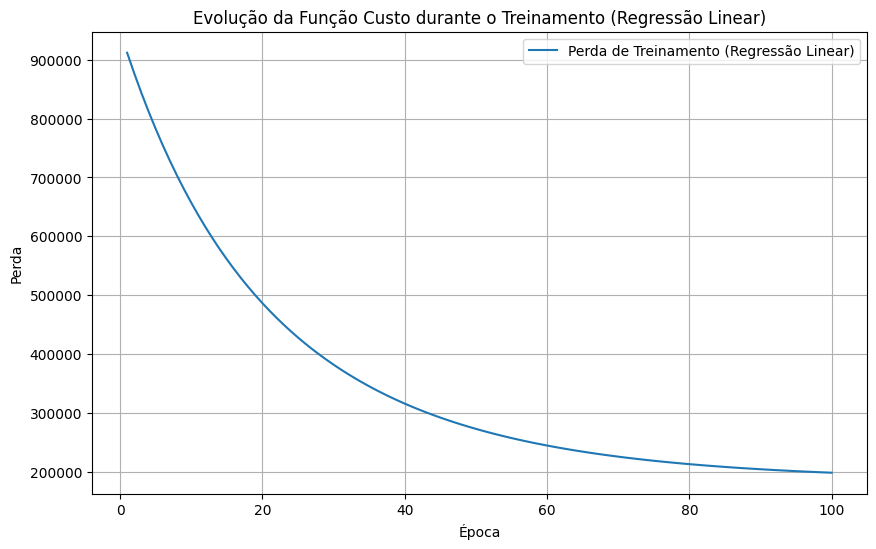

In [183]:
linear_model.eval()
with torch.no_grad():
    y_pred_linear = linear_model(X_val_tensor).numpy()

mse_linear = mean_squared_error(y_val, y_pred_linear)
mae_linear = mean_absolute_error(y_val, y_pred_linear)

print(f'MSE Regressão Linear: {mse_linear:.4f}')
print(f'MAE Regressão Linear: {mae_linear:.4f}')

plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs + 1), train_losses, label='Perda de Treinamento (Regressão Linear)')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.title('Evolução da Função Custo durante o Treinamento (Regressão Linear)')
plt.grid(True)
plt.legend()
plt.show()


### **Multi layer Perceptron (MLP)**

Um Perceptron Multicamadas (MLP) é uma classe de rede neural artificial feedforward. O MLP é composto por pelo menos três camadas de nós: uma camada de entrada, uma camada oculta e uma camada de saída. Exceto pelos nós de entrada, cada nó é um neurônio que utiliza uma função de ativação não linear. 

O MLP utiliza uma técnica de aprendizado supervisionado chamada retropropagação (também citado como backfoward) para treinamento.

##### Estrutura de um MLP semelhante a implementada: 

<center><img alt="Foto sistema de bicicletas" width="35%" src="https://miro.medium.com/v2/resize:fit:720/format:webp/1*-IPQlOd46dlsutIbUq1Zcw.png"></center>

In [184]:
class MLPModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim=1):
        super(MLPModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x


In [185]:
def train_mlp_model(hidden_dim, num_epochs=100):
    mlp_model = MLPModel(input_dim=X_train.shape[1], hidden_dim=hidden_dim)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(mlp_model.parameters(), lr=0.01)
    
    train_losses = []
    for epoch in range(num_epochs):
        mlp_model.train()
        optimizer.zero_grad()
        
        outputs = mlp_model(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
    
    return mlp_model, train_losses


In [186]:
hidden_dims = [30,60,90,120,150,180]
best_mlp_model = None
best_losses = []
best_mse = float('inf')

for hidden_dim in hidden_dims:
    print(f'Treinando MLP com {hidden_dim} neurônios na camada oculta...')
    model, losses = train_mlp_model(hidden_dim)
    
    model.eval()
    with torch.no_grad():
        y_pred_mlp = model(X_val_tensor).numpy()
    
    mse_mlp = mean_squared_error(y_val, y_pred_mlp)
    
    if mse_mlp < best_mse:
        best_mse = mse_mlp
        best_mlp_model = model
        best_losses = losses

print(f'MSE Melhor MLP: {best_mse:.4f}')


Treinando MLP com 30 neurônios na camada oculta...
Treinando MLP com 60 neurônios na camada oculta...
Treinando MLP com 90 neurônios na camada oculta...
Treinando MLP com 120 neurônios na camada oculta...
Treinando MLP com 150 neurônios na camada oculta...
Treinando MLP com 180 neurônios na camada oculta...
MSE Melhor MLP: 225357.2335


### **Resultados da MLP**


É perceptível que conforme o número de neurônios na camada oculta almenta melhores os resultados gerados. Em geral, mais neurônios permitem que o modelo capture mais complexidade, mas também pode levar a problemas de `overfitting`. Já que é um hiperparâmetro importante que pode afetar diretamente a capacidade do modelo de aprender padrões complexos.


A Melhor Configuração apresentou obteve um MSE de `225357.2335`. O mérito pode ser dado é a configuração com o número ótimo de neurônios na camada oculta. 

Escolha do Modelo: O valor de 193,667.0316 é o menor MSE encontrado, o que significa que o modelo MLP treinado com esta configuração de neurônios na camada oculta tem o melhor desempenho entre as opções testadas. O modelo com esse número de neurônios foi o que melhor equilibrava a capacidade de aprender e a generalização para o conjunto de validação.

In [187]:
best_mlp_model.eval()
with torch.no_grad():
    y_pred_mlp = best_mlp_model(X_val_tensor).numpy()

mse_mlp = mean_squared_error(y_val, y_pred_mlp)
mae_mlp = mean_absolute_error(y_val, y_pred_mlp)

print(f'MSE Melhor MLP: {mse_mlp:.4f}')
print(f'MAE Melhor MLP: {mae_mlp:.4f}')


MSE Melhor MLP: 225357.2335
MAE Melhor MLP: 310.9569


### **Evolução da função custo ao longo das épocas**

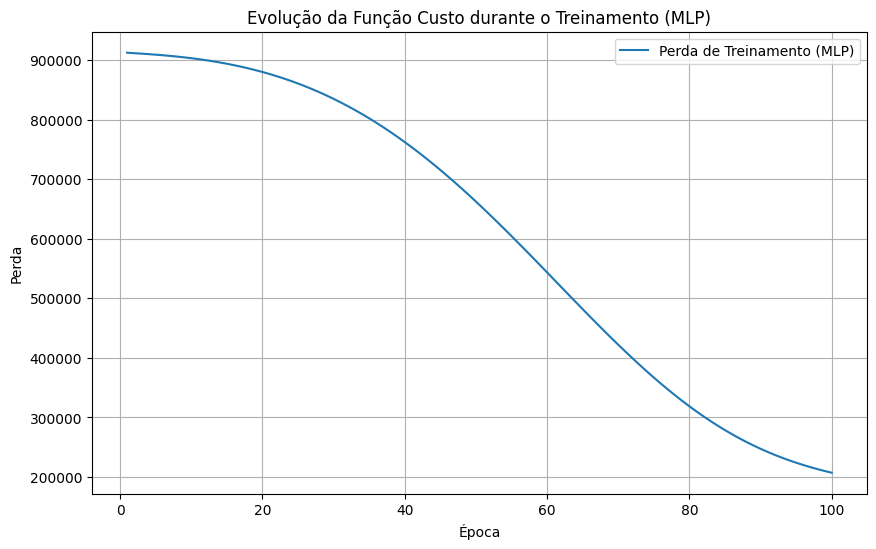

In [188]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(best_losses) + 1), best_losses, label='Perda de Treinamento (MLP)')
plt.xlabel('Época')
plt.ylabel('Perda')
plt.title('Evolução da Função Custo durante o Treinamento (MLP)')
plt.grid(True)
plt.legend()
plt.show()

### **Comparações das predições com Valores Reais**

##### 1.Regressão Linear

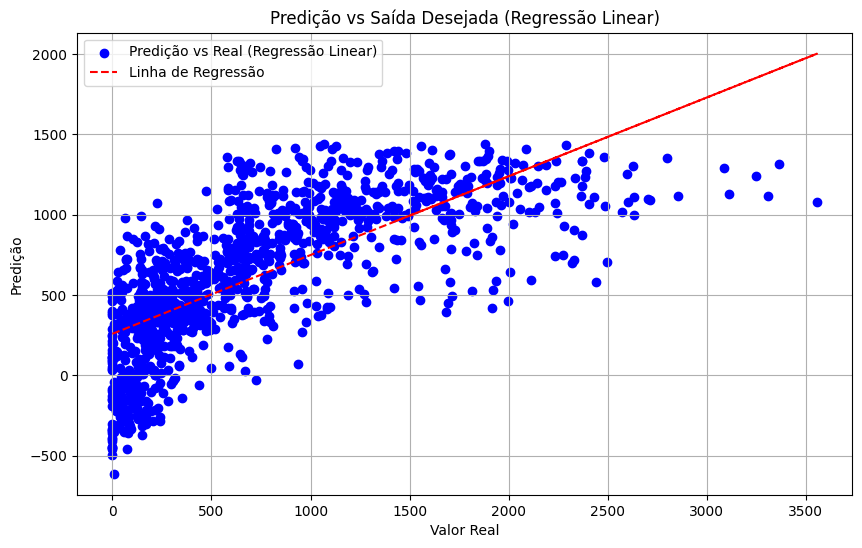

In [189]:
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_linear, color='blue', label='Predição vs Real (Regressão Linear)')

coef_linear = np.polyfit(y_val.values.flatten(), y_pred_linear.flatten(), 1)
poly1d_fn_linear = np.poly1d(coef_linear)
plt.plot(y_val, poly1d_fn_linear(y_val), color='red', linestyle='--', label='Linha de Regressão')

plt.xlabel('Valor Real')
plt.ylabel('Predição')
plt.title('Predição vs Saída Desejada (Regressão Linear)')
plt.grid(True)
plt.legend()
plt.show()


##### 2. Multi layer Perceptron (MLP) 


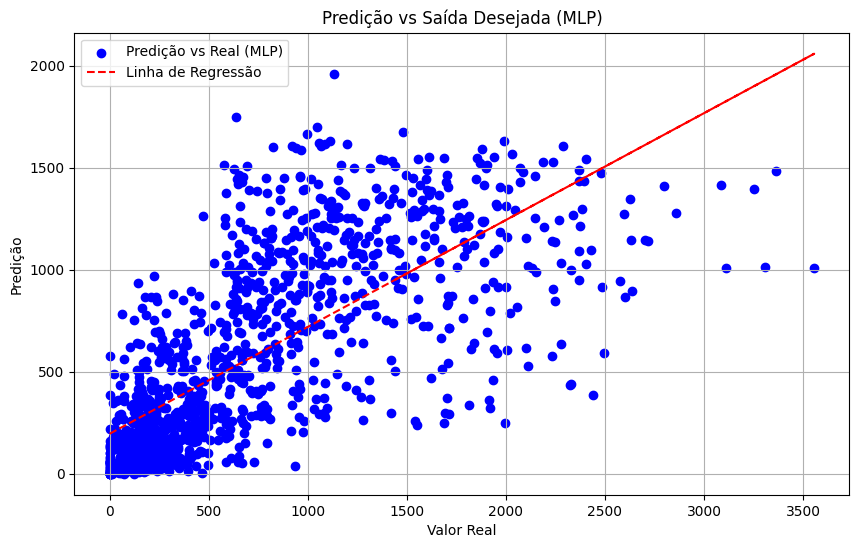

In [190]:
plt.figure(figsize=(10, 6))
plt.scatter(y_val, y_pred_mlp, color='blue', label='Predição vs Real (MLP)')

coef_mlp = np.polyfit(y_val.values.flatten(), y_pred_mlp.flatten(), 1)
poly1d_fn_mlp = np.poly1d(coef_mlp)
plt.plot(y_val, poly1d_fn_mlp(y_val), color='red', linestyle='--', label='Linha de Regressão')

plt.xlabel('Valor Real')
plt.ylabel('Predição')
plt.title('Predição vs Saída Desejada (MLP)')
plt.grid(True)
plt.legend()
plt.show()


### **Implementação com o cross-validation**